# Dog Breeds Image Classifier
### Our model can recognize five different breeds of dogs: German Sherpherd, Siberian Husky, Doberman Pinscher, Shih Tzu and Pug!


 We first make the set up of the notebook and import some libraries 

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 16.7 MB/s 
     |████████████████████████████████| 46 kB 5.6 MB/s 
     |████████████████████████████████| 188 kB 34.1 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 51 kB 411 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *
from zipfile import ZipFile
import requests
import urllib.request

### Downloading and extracting the dataset

Using the variable 'dog_breeds' we set up all the categories that our model can predict, and then we download directly from the [GitHub repository of our project](https://github.com/mateuseap/Final-Project) the dataset containing images of the five different breeds of dog. After downloading the dataset, we use a function to extract it, because it is downloaded as a '.zip' file.

In [42]:
dog_breeds = 'german_shepherd','siberian_husky','doberman_pinscher','shih_tzu','pug'

path = URLs.path('dataset')
if not path.exists():
    path.mkdir(parents=true)

url = 'https://codeload.github.com/mateuseap/Final-Project/zip/refs/heads/main'
r = requests.get(url)

with open(path/'dataset.zip', "wb") as code:
    code.write(r.content)

urllib.request.urlretrieve(url)

with ZipFile(path/'dataset.zip', 'r') as zipObj:
   zipObj.extractall(path)

path = path/'Final-Project-main/dataset'
path.ls()

(#5) [Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/pug'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/doberman_pinscher'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/german_shepherd'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/siberian_husky')]

Now we check if there are some corrupted images in our dataset and then remove them.

In [43]:
fns = get_image_files(path)
fns

(#646) [Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000086.jpg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000096.jpeg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000001.jpg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000082.jpeg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000038.jpg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000089.jpg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000028.jpg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000030.png'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000026.jpg'),Path('/root/.fastai/archive/dataset/Final-Project-main/dataset/shih_tzu/00000025.jpg')...]

In [44]:
failed = verify_images(fns)
warnings.filterwarnings("ignore", "(Possibly )?Corrupt EXIF data", UserWarning)

In [45]:
failed.map(Path.unlink)

(#0) []

### Creating a DataBlock and a DataLoader

In [46]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42), #30% to the validation set, random image distribution
    get_y=parent_label,
    item_tfms=Resize(128))

After creating the `DataBlock` above, we create a `DataLoader` to hold our data and suplly us with usefull functions.

In [47]:
dls = dogs.dataloaders(path)

Now, we can check what is inside of our `DataLoader`. Let's see a batch with fifteen images from our valid dataset.

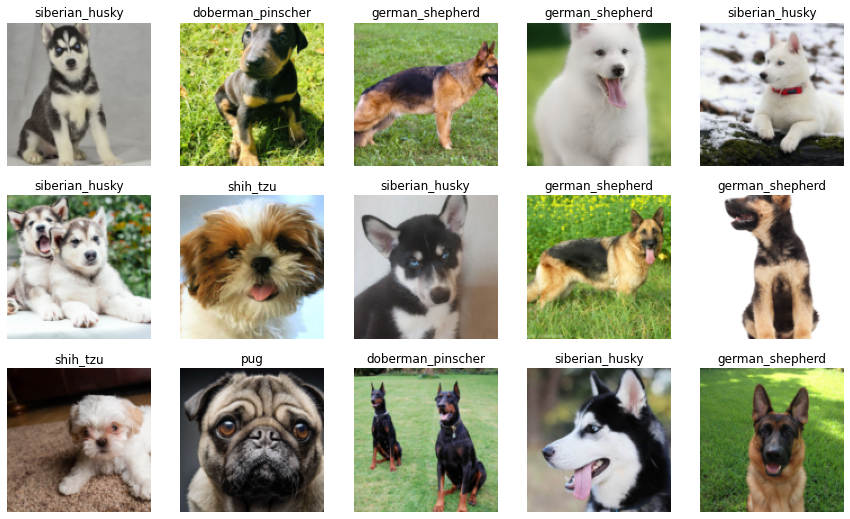

In [48]:
dls.valid.show_batch(max_n=15, nrows=3)

###Doing image augmentation

Here is an example of image augmentation using `aug_transforms`.

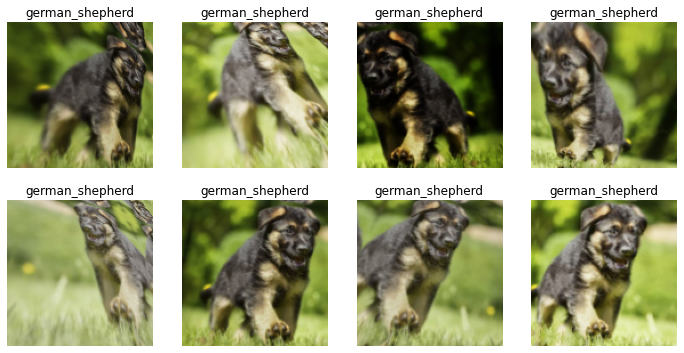

In [49]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Below we apply `aug_transforms `to our whole dataset. That's a good thing to do because the model will train with more varied image positions, quality, and angles.

In [50]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

### Training our model

We already have preperad our data and now we're ready to train our model!

In [51]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.934361,0.049293,0.015544,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.116561,0.048808,0.005181,00:22
1,0.078559,0.078732,0.010363,00:22
2,0.057034,0.081784,0.015544,00:22
3,0.046257,0.079277,0.015544,00:22


### Checking the results after the training process

We use the confusion matrix to see the results of our model and check if it has done some wrong predictions.

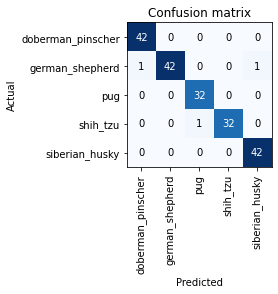

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Now we can plot the predictions with the higher loss and see if there are some images with wrong labels or images that simply shouldn't be in our dataset.

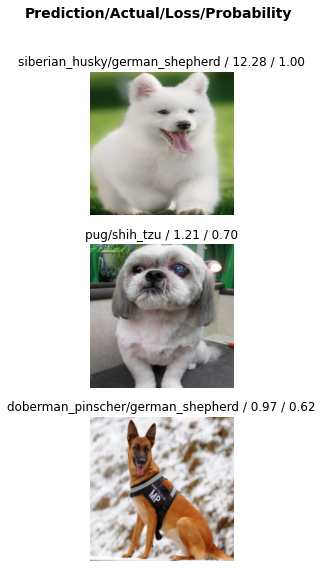

In [53]:
interp.plot_top_losses(3, nrows=3)

Above our model has helped us to see if there are images that shouldn't be in our dataset using `interp.plot_top_losses`. If we want, we can delete these images using the widget below.

In [54]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [41]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After cleaning our dataset using our model to help us, we can retrain our model and increase its accuracy.

###Exporting the trained model to a '.pkl' file

In [55]:
learn.export()

In [56]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [57]:
learn_inf = load_learner(path/'export.pkl')

After exporting the trained model to a '.pkl' file, we use it to predict what is the breed of the dog in the image below:

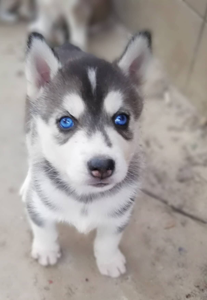

In [58]:
path = URLs.path('dataset')
path = path/'Final-Project-main/dataset'

im = Image.open(path/'siberian_husky/00000117.jpg')
im.to_thumb(300,300)

In [59]:
learn_inf.predict(path/'siberian_husky/00000111.jpg')

('siberian_husky',
 tensor(4),
 tensor([9.5955e-07, 1.5907e-06, 3.6501e-07, 3.3736e-05, 9.9996e-01]))

It predicted right! It is a SIberian Husky, the tensor above show us the probabilty of the the image be of one of the five breeds.

In [60]:
learn_inf.dls.vocab

['doberman_pinscher', 'german_shepherd', 'pug', 'shih_tzu', 'siberian_husky']

The vocab is simply the categories that our model can recognize.